# Frequency correlation plots for natural populations

Example code for how to calculate frequency correlation plots from augur forecasting builds.

In [1]:
import altair as alt
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from scipy.stats import pearsonr
import seaborn as sns

%matplotlib inline

In [2]:
sns.set_style("white")
plt.style.use("huddlej")

In [3]:
mpl.rcParams['savefig.dpi'] = 200
mpl.rcParams['figure.dpi'] = 200
mpl.rcParams['font.weight'] = 300
mpl.rcParams['axes.labelweight'] = 300
mpl.rcParams['font.size'] = 18

In [4]:
!pwd

/Users/jlhudd/projects/nextstrain/flu-forecasting/analyses


In [5]:
def matthews_correlation_coefficient(tp, tn, fp, fn):
    """Return Matthews correlation coefficient for values from a confusion matrix.
    Implementation is based on the definition from wikipedia:

    https://en.wikipedia.org/wiki/Matthews_correlation_coefficient
    """
    numerator = (tp * tn) - (fp * fn)
    denominator = np.sqrt((tp + fp) * (tp + fn) * (tn + fp) * (tn + fn))
    if denominator == 0:
            denominator = 1

    return float(numerator) / denominator

def get_matthews_correlation_coefficient_for_data_frame(freq_df, return_confusion_matrix=False):
        """Calculate Matthew's correlation coefficient from a given pandas data frame
        with columns for initial, observed, and predicted frequencies.
        """
        observed_growth = (freq_df["frequency_final"] > freq_df["frequency"])
        predicted_growth = (freq_df["projected_frequency"] > freq_df["frequency"])
        true_positives = ((observed_growth) & (predicted_growth)).sum()
        false_positives= ((~observed_growth) & (predicted_growth)).sum()

        observed_decline = (freq_df["frequency_final"] <= freq_df["frequency"])
        predicted_decline = (freq_df["projected_frequency"] <= freq_df["frequency"])
        true_negatives = ((observed_decline) & (predicted_decline)).sum()
        false_negatives = ((~observed_decline) & (predicted_decline)).sum()

        mcc = matthews_correlation_coefficient(
            true_positives,
            true_negatives,
            false_positives,
            false_negatives
        )

        if return_confusion_matrix:
            confusion_matrix = {
                "tp": true_positives,
                "tn": true_negatives,
                "fp": false_positives,
                "fn": false_negatives
            }
            
            return mcc, confusion_matrix
        else:
            return mcc

## Load data

In [6]:
data_root = "../results/builds/natural/natural_sample_1_with_10_vpm/"

In [7]:
tips = pd.read_csv(
    "%s/tip_attributes_with_weighted_distances.tsv" % data_root,
    sep="\t",
    parse_dates=["timepoint"],
    usecols=["strain", "timepoint", "frequency"]
)

In [8]:
tips.head(1)

,strain,timepoint,frequency
0,A/England/121/1995,1995-10-01,0.003272


In [9]:
tips_to_clades = pd.read_csv("%s/tips_to_clades.tsv" % data_root, sep="\t", parse_dates=["timepoint"])

In [10]:
tips_to_clades = tips_to_clades.query("timepoint == '2015-10-01'").drop(columns=["timepoint", "depth"]).copy()

In [11]:
tips_to_clades.head()

,tip,clade_membership
1486269,A/Jitie/1/1995,8e08f7f
1486270,A/NewYork/654/1994,509b83b
1486271,A/NewYork/654/1994,8e08f7f
1486272,A/NewYork/655/1994,509b83b
1486273,A/NewYork/655/1994,8e08f7f


In [12]:
tips_to_clades.shape

(132981, 2)

In [13]:
forecasts = pd.read_csv(
    "%s/natural_sample_1_with_10_vpm_lbi-cTiter-ne_star_forecast.tsv" % data_root,
    sep="\t",
    parse_dates=["timepoint"],
    usecols=["timepoint", "strain", "fitness", "frequency", "projected_frequency"]
)

In [14]:
forecasts.head(1)

,timepoint,strain,frequency,fitness,projected_frequency
0,1995-10-01,A/England/121/1995,0.003272,-1.8544,0.00041


## Find large clades

Find all clades with an initial frequency some minimum value (e.g., >15%).

In [15]:
tips.head()

,strain,timepoint,frequency
0,A/England/121/1995,1995-10-01,0.003272
1,A/England/255/1995,1995-10-01,0.005768
2,A/England/258/1995,1995-10-01,0.044475
3,A/England/263/1995,1995-10-01,0.053013
4,A/England/268/1995,1995-10-01,0.069979


In [16]:
clade_tip_initial_frequencies = tips_to_clades.merge(
    tips,
    how="left",
    left_on=["tip"],
    right_on=["strain"]
).drop(columns=["strain"])

In [17]:
clade_tip_initial_frequencies["frequency"] = clade_tip_initial_frequencies["frequency"].fillna(0.0)

In [18]:
clade_tip_initial_frequencies.head()

,tip,clade_membership,timepoint,frequency
0,A/Jitie/1/1995,8e08f7f,1995-10-01,0.000164
1,A/NewYork/654/1994,509b83b,NaT,0.000000
2,A/NewYork/654/1994,8e08f7f,NaT,0.000000
3,A/NewYork/655/1994,509b83b,NaT,0.000000
4,A/NewYork/655/1994,8e08f7f,NaT,0.000000


In [19]:
initial_clade_frequencies = clade_tip_initial_frequencies.groupby(["timepoint", "clade_membership"])["frequency"].sum().reset_index()

In [20]:
initial_clade_frequencies.head()

,timepoint,clade_membership,frequency
0,1995-10-01,02e323e,0.154227
1,1995-10-01,1a74f77,0.188460
2,1995-10-01,35491c6,0.610839
3,1995-10-01,3e24e68,0.093671
4,1995-10-01,45e0162,0.062900


In [21]:
initial_clade_frequencies.query("clade_membership == 'c139e7c'")

,timepoint,clade_membership,frequency
2026,2011-04-01,c139e7c,0.040908
2134,2011-10-01,c139e7c,0.476381
2231,2012-04-01,c139e7c,0.748942
2336,2012-10-01,c139e7c,0.695808
2430,2013-04-01,c139e7c,0.915574
2525,2013-10-01,c139e7c,0.971921
2630,2014-04-01,c139e7c,0.999945
2743,2014-10-01,c139e7c,1.000022
2855,2015-04-01,c139e7c,0.999921
2964,2015-10-01,c139e7c,1.000002


In [22]:
initial_clades = initial_clade_frequencies.query("frequency > 0.15 & timepoint >= '2002-10-01' & timepoint < '2015-04-01'").copy()

In [23]:
initial_clades.head()

,timepoint,clade_membership,frequency
543,2002-10-01,02e323e,0.999988
544,2002-10-01,048f8ca,0.999988
545,2002-10-01,05a6dc1,0.528667
546,2002-10-01,09e68a2,0.999988
551,2002-10-01,35491c6,0.999988


In [24]:
initial_clades.tail()

,timepoint,clade_membership,frequency
2763,2014-10-01,f2ec31a,0.996242
2764,2014-10-01,f321e53,1.000022
2765,2014-10-01,f3f16af,1.000022
2768,2014-10-01,f8b8996,1.000022
2770,2014-10-01,fd5608c,1.000022


In [25]:
initial_clades.shape

(947, 3)

In [26]:
initial_clades[initial_clades["clade_membership"] == "c139e7c"]

,timepoint,clade_membership,frequency
2134,2011-10-01,c139e7c,0.476381
2231,2012-04-01,c139e7c,0.748942
2336,2012-10-01,c139e7c,0.695808
2430,2013-04-01,c139e7c,0.915574
2525,2013-10-01,c139e7c,0.971921
2630,2014-04-01,c139e7c,0.999945
2743,2014-10-01,c139e7c,1.000022


## Find future frequencies of large clades

In [27]:
initial_clades["final_timepoint"] = initial_clades["timepoint"] + pd.DateOffset(months=12)

In [28]:
initial_and_observed_clade_frequencies = initial_clades.merge(
    clade_tip_initial_frequencies,
    left_on=["final_timepoint", "clade_membership"],
    right_on=["timepoint", "clade_membership"],
    suffixes=["", "_final"]
).groupby(["timepoint", "clade_membership", "frequency"])["frequency_final"].sum().reset_index()

In [29]:
initial_and_observed_clade_frequencies.shape

(943, 4)

In [30]:
initial_and_observed_clade_frequencies.head()

,timepoint,clade_membership,frequency,frequency_final
0,2002-10-01,02e323e,0.999988,0.999961
1,2002-10-01,048f8ca,0.999988,0.999961
2,2002-10-01,05a6dc1,0.528667,0.126659
3,2002-10-01,09e68a2,0.999988,0.999961
4,2002-10-01,35491c6,0.999988,0.999961


In [31]:
initial_and_observed_clade_frequencies.query("clade_membership == 'c139e7c'")

,timepoint,clade_membership,frequency,frequency_final
632,2011-10-01,c139e7c,0.476381,0.695808
677,2012-04-01,c139e7c,0.748942,0.915574
723,2012-10-01,c139e7c,0.695808,0.971921
773,2013-04-01,c139e7c,0.915574,0.999945
822,2013-10-01,c139e7c,0.971921,1.000022
872,2014-04-01,c139e7c,0.999945,0.999921
926,2014-10-01,c139e7c,1.000022,1.000002


In [32]:
initial_and_observed_clade_frequencies["observed_growth_rate"] = (
    initial_and_observed_clade_frequencies["frequency_final"] / initial_and_observed_clade_frequencies["frequency"]
)

In [33]:
initial_and_observed_clade_frequencies.head()

,timepoint,clade_membership,frequency,frequency_final,observed_growth_rate
0,2002-10-01,02e323e,0.999988,0.999961,0.999973
1,2002-10-01,048f8ca,0.999988,0.999961,0.999973
2,2002-10-01,05a6dc1,0.528667,0.126659,0.239582
3,2002-10-01,09e68a2,0.999988,0.999961,0.999973
4,2002-10-01,35491c6,0.999988,0.999961,0.999973


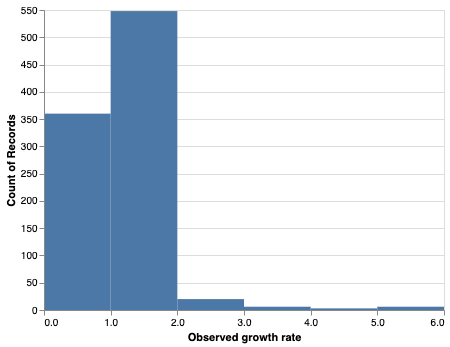

In [34]:
alt.Chart(initial_and_observed_clade_frequencies).mark_rect().encode(
    x=alt.X("observed_growth_rate:Q", bin=True, title="Observed growth rate"),
    y="count()"
)

## Find estimated future frequencies of large clades

Use the LBI model as an example, first.

In [35]:
clade_tip_estimated_frequencies = tips_to_clades.merge(
    forecasts,
    how="left",
    left_on=["tip"],
    right_on=["strain"]
).drop(columns=["strain", "fitness"])

In [36]:
clade_tip_estimated_frequencies.head()

,tip,clade_membership,timepoint,frequency,projected_frequency
0,A/Jitie/1/1995,8e08f7f,1995-10-01,0.000164,0.000005
1,A/NewYork/654/1994,509b83b,NaT,NaN,NaN
2,A/NewYork/654/1994,8e08f7f,NaT,NaN,NaN
3,A/NewYork/655/1994,509b83b,NaT,NaN,NaN
4,A/NewYork/655/1994,8e08f7f,NaT,NaN,NaN


In [37]:
clade_tip_estimated_frequencies["frequency"] = clade_tip_estimated_frequencies["frequency"].fillna(0.0)
clade_tip_estimated_frequencies["projected_frequency"] = clade_tip_estimated_frequencies["projected_frequency"].fillna(0.0)

In [38]:
clade_tip_estimated_frequencies.head()

,tip,clade_membership,timepoint,frequency,projected_frequency
0,A/Jitie/1/1995,8e08f7f,1995-10-01,0.000164,0.000005
1,A/NewYork/654/1994,509b83b,NaT,0.000000,0.000000
2,A/NewYork/654/1994,8e08f7f,NaT,0.000000,0.000000
3,A/NewYork/655/1994,509b83b,NaT,0.000000,0.000000
4,A/NewYork/655/1994,8e08f7f,NaT,0.000000,0.000000


In [39]:
estimated_clade_frequencies = clade_tip_estimated_frequencies.groupby(
    ["timepoint", "clade_membership"]
).aggregate({"projected_frequency": "sum", "frequency": "sum"}).reset_index()

In [40]:
estimated_clade_frequencies.head()

,timepoint,clade_membership,projected_frequency,frequency
0,1995-10-01,02e323e,0.003847,0.154227
1,1995-10-01,1a74f77,0.024219,0.188460
2,1995-10-01,35491c6,0.138394,0.610839
3,1995-10-01,3e24e68,0.001283,0.093671
4,1995-10-01,45e0162,0.008687,0.062900


In [41]:
complete_clade_frequencies = initial_and_observed_clade_frequencies.merge(
    estimated_clade_frequencies,
    on=["timepoint", "clade_membership"],
    suffixes=["", "_other"]
)

In [42]:
complete_clade_frequencies["estimated_growth_rate"] = (
    complete_clade_frequencies["projected_frequency"] / complete_clade_frequencies["frequency"]
)

In [43]:
complete_clade_frequencies["year"] = complete_clade_frequencies["timepoint"].dt.year

In [44]:
complete_clade_frequencies.head()

,timepoint,clade_membership,frequency,frequency_final,observed_growth_rate,projected_frequency,frequency_other,estimated_growth_rate,year
0,2002-10-01,02e323e,0.999988,0.999961,0.999973,1.000000,0.999988,1.000012,2002
1,2002-10-01,048f8ca,0.999988,0.999961,0.999973,1.000000,0.999988,1.000012,2002
2,2002-10-01,05a6dc1,0.528667,0.126659,0.239582,0.300835,0.528667,0.569044,2002
3,2002-10-01,09e68a2,0.999988,0.999961,0.999973,1.000000,0.999988,1.000012,2002
4,2002-10-01,35491c6,0.999988,0.999961,0.999973,1.000000,0.999988,1.000012,2002


In [45]:
complete_clade_frequencies.shape

(943, 9)

In [46]:
r, p = pearsonr(
    complete_clade_frequencies["observed_growth_rate"],
    complete_clade_frequencies["estimated_growth_rate"]
)

In [47]:
mcc, confusion_matrix = get_matthews_correlation_coefficient_for_data_frame(complete_clade_frequencies, True)

In [48]:
mcc

0.4330478632282064

In [49]:
growth_accuracy = confusion_matrix["tp"] / float(confusion_matrix["tp"] + confusion_matrix["fp"])
growth_accuracy

0.7612403100775194

In [50]:
decline_accuracy = confusion_matrix["tn"] / float(confusion_matrix["tn"] + confusion_matrix["fn"])
decline_accuracy

0.6912751677852349

In [51]:
min_growth_rate = 0
max_growth_rate = complete_clade_frequencies.loc[:, ["observed_growth_rate", "estimated_growth_rate"]].max().max() + 0.2

In [89]:
pseudofrequency = 0.001

In [99]:
complete_clade_frequencies["log_observed_growth_rate"] = (
    np.log10((complete_clade_frequencies["frequency_final"] + pseudofrequency) / (complete_clade_frequencies["frequency"] + pseudofrequency))
)

complete_clade_frequencies["log_estimated_growth_rate"] = (
    np.log10((complete_clade_frequencies["projected_frequency"] + pseudofrequency) / (complete_clade_frequencies["frequency"] + pseudofrequency))
)

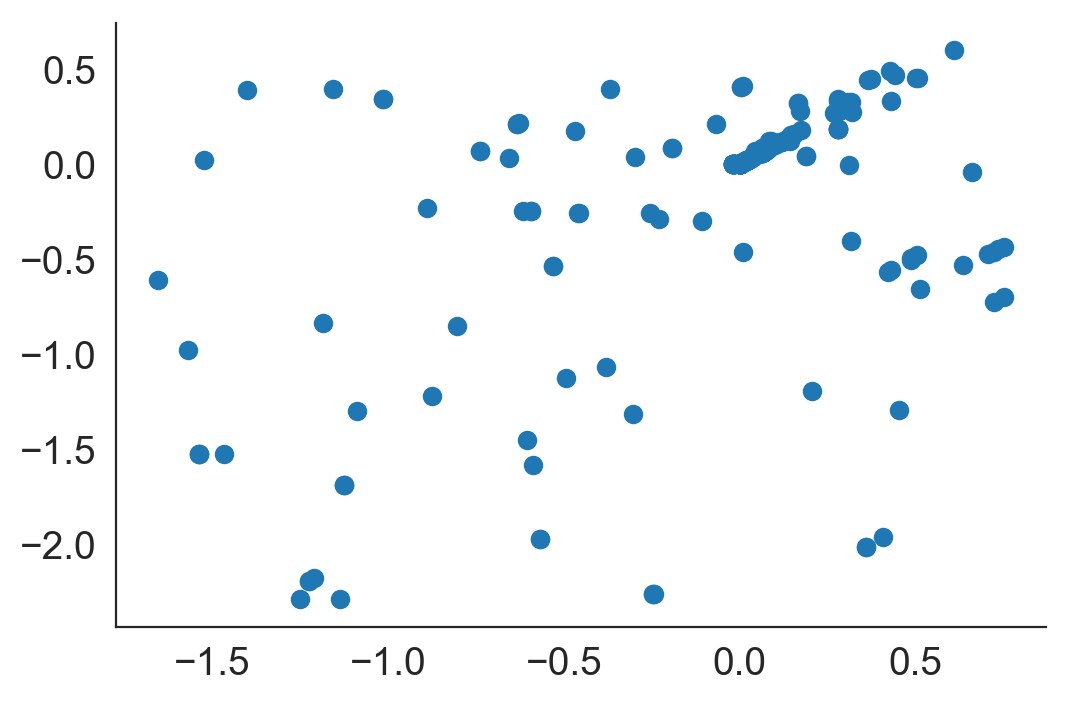

In [100]:
plt.plot(complete_clade_frequencies["log_observed_growth_rate"], complete_clade_frequencies["log_estimated_growth_rate"], "o")

In [70]:
#complete_clade_frequencies["log_observed_growth_rate"] = np.log(complete_clade_frequencies["observed_growth_rate"])
#complete_clade_frequencies["log_estimated_growth_rate"] = np.log(complete_clade_frequencies["estimated_growth_rate"])

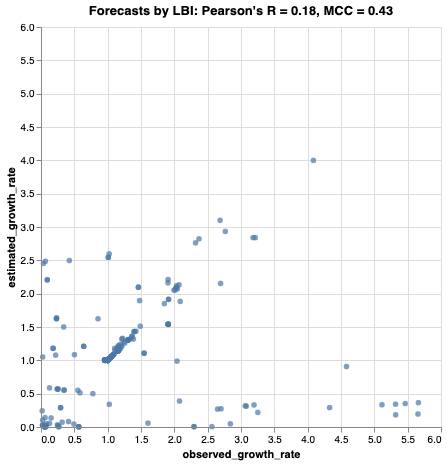

In [53]:
tooltip_attributes = ["observed_growth_rate:Q", "estimated_growth_rate:Q", "timepoint:N", "frequency:Q", "frequency_final:Q",
                      "projected_frequency:Q", "clade_membership:N"]

chart = alt.Chart(complete_clade_frequencies).mark_circle().encode(
    alt.X("observed_growth_rate:Q", scale=alt.Scale(domain=(min_growth_rate, max_growth_rate))),
    alt.Y("estimated_growth_rate:Q", scale=alt.Scale(domain=(min_growth_rate, max_growth_rate))),
    alt.Tooltip(tooltip_attributes)
).properties(
    width=400,
    height=400,
    title="Forecasts by LBI: Pearson's R = %.2f, MCC = %.2f" % (r, mcc)
)

chart.save("forecast_growth_correlation_natural_lbi.svg")
chart

In [54]:
complete_clade_frequencies.head()

,timepoint,clade_membership,frequency,frequency_final,observed_growth_rate,projected_frequency,frequency_other,estimated_growth_rate,year,log_observed_growth_rate,log_estimated_growth_rate
0,2002-10-01,02e323e,0.999988,0.999961,0.999973,1.000000,0.999988,1.000012,2002,-0.000027,0.000012
1,2002-10-01,048f8ca,0.999988,0.999961,0.999973,1.000000,0.999988,1.000012,2002,-0.000027,0.000012
2,2002-10-01,05a6dc1,0.528667,0.126659,0.239582,0.300835,0.528667,0.569044,2002,-1.428860,-0.563797
3,2002-10-01,09e68a2,0.999988,0.999961,0.999973,1.000000,0.999988,1.000012,2002,-0.000027,0.000012
4,2002-10-01,35491c6,0.999988,0.999961,0.999973,1.000000,0.999988,1.000012,2002,-0.000027,0.000012


In [102]:
upper_limit = np.ceil(complete_clade_frequencies.loc[:, ["observed_growth_rate", "estimated_growth_rate"]].max().max())

log_lower_limit = complete_clade_frequencies.loc[:, ["log_observed_growth_rate", "log_estimated_growth_rate"]].min().min() - 0.1
log_upper_limit = np.ceil(complete_clade_frequencies.loc[:, ["log_observed_growth_rate", "log_estimated_growth_rate"]].max().max()) + 0.1

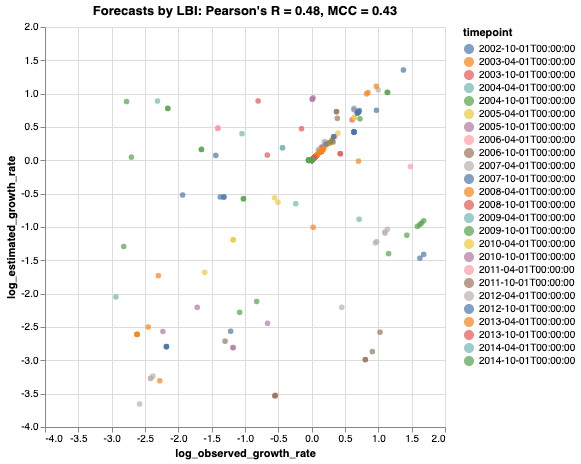

In [83]:
tooltip_attributes = ["observed_growth_rate:Q", "estimated_growth_rate:Q", "timepoint:N", "frequency:Q", "frequency_final:Q",
                      "projected_frequency:Q", "clade_membership:N"]

chart = alt.Chart(complete_clade_frequencies).mark_circle().encode(
    alt.X("log_observed_growth_rate:Q", scale=alt.Scale(domain=(log_lower_limit, log_upper_limit))),
    alt.Y("log_estimated_growth_rate:Q", scale=alt.Scale(domain=(log_lower_limit, log_upper_limit))),
    alt.Color("timepoint:N"),
    alt.Tooltip(tooltip_attributes)
).properties(
    width=400,
    height=400,
    title="Forecasts by LBI: Pearson's R = %.2f, MCC = %.2f" % (r, mcc)
)

#chart.save("forecast_log_growth_correlation_natural_lbi.svg")
chart

In [103]:
log_lower_limit

-2.388538839862568

In [104]:
complete_clade_frequencies.loc[:, ["log_observed_growth_rate", "log_estimated_growth_rate"]].min().min()

-2.288538839862568

In [107]:
r, p = pearsonr(
    complete_clade_frequencies["log_observed_growth_rate"],
    complete_clade_frequencies["log_estimated_growth_rate"]
)

In [108]:
r

0.4838212449559336

In [109]:
p

1.723239939912282e-56

In [110]:
pearsonr(
    complete_clade_frequencies["observed_growth_rate"],
    complete_clade_frequencies["estimated_growth_rate"]
)

(0.1779888094354804, 3.744893470478207e-08)

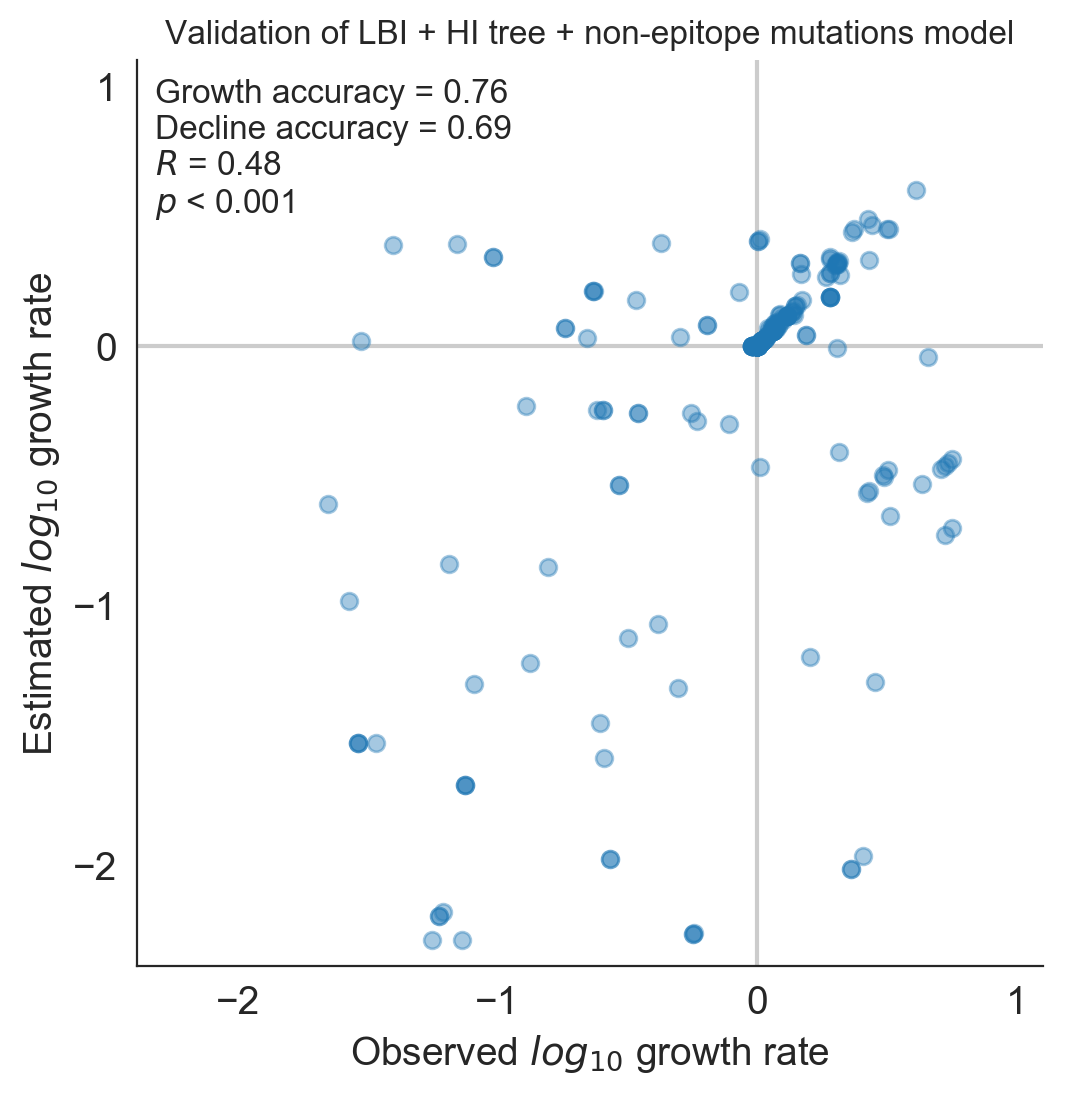

In [111]:
fig, ax = plt.subplots(1, 1, figsize=(6, 6))
ax.plot(
    complete_clade_frequencies["log_observed_growth_rate"],
    complete_clade_frequencies["log_estimated_growth_rate"],
    "o",
    alpha=0.4
)

ax.axhline(color="#cccccc", zorder=-5)
ax.axvline(color="#cccccc", zorder=-5)

if p < 0.001:
    p_value = "$p$ < 0.001"
else:
    p_value = "$p$ = %.3f" % p

ax.text(
    0.02,
    0.9,
    "Growth accuracy = %.2f\nDecline accuracy = %.2f\n$R$ = %.2f\n%s" % (growth_accuracy, decline_accuracy, r, p_value),
    fontsize=12,
    horizontalalignment="left",
    verticalalignment="center",
    transform=ax.transAxes
)

ax.set_xlabel("Observed $log_{10}$ growth rate")
ax.set_ylabel("Estimated $log_{10}$ growth rate")
ax.set_title("Validation of LBI + HI tree + non-epitope mutations model", fontsize=12)

ticks = np.arange(-6, 4, 1)
ax.set_xticks(ticks)
ax.set_yticks(ticks)

ax.set_xlim(log_lower_limit, log_upper_limit)
ax.set_ylim(log_lower_limit, log_upper_limit)
ax.set_aspect("equal")

plt.savefig("../manuscript/figures/validation-of-best-model-for-natural-populations.pdf")

In [65]:
complete_clade_frequencies.shape

(943, 11)

In [66]:
initial_and_observed_clade_frequencies.query("clade_membership == 'c139e7c'")

,timepoint,clade_membership,frequency,frequency_final,observed_growth_rate
632,2011-10-01,c139e7c,0.476381,0.695808,1.460612
677,2012-04-01,c139e7c,0.748942,0.915574,1.222490
723,2012-10-01,c139e7c,0.695808,0.971921,1.396824
773,2013-04-01,c139e7c,0.915574,0.999945,1.092151
822,2013-10-01,c139e7c,0.971921,1.000022,1.028913
872,2014-04-01,c139e7c,0.999945,0.999921,0.999976
926,2014-10-01,c139e7c,1.000022,1.000002,0.999980
